In [1]:
import random

from itertools import cycle

import src.network_components as nc
import src.loss_functions as lf

## Run Neural Network

#### Define test data

In [2]:
xs = [[random.randint(0, 9) for _ in range(3)] for _ in range(500)]
ys = [[4 * x[0] + x[1] + x[2]] for x in xs]

In [3]:
in_cycle = cycle(xs)
target_cycle = cycle(ys)

#### Run epochs

In [4]:
LEARNING_RATE = 0.0001

In [5]:
num_epochs = 500
weights, biases = nc.init_NN(3, 3, 3, 1)
losses = []
for i in range(num_epochs):
    x = next(in_cycle)
    target = next(target_cycle)
    _out = nc.forward(x, weights, biases)
    loss = lf.MSE(_out[-1], target)
    losses.append(loss)
    weights, biases = nc.backprop(weights, biases, _out, target, lf.MSE, LEARNING_RATE)
    if i % (num_epochs // 10) == 0:
        print(f"Epoch {i}: {loss}")
    if loss < 1e-10:
        break

Epoch 0: 5.25968906427436
Epoch 50: 15.77379052654642
Epoch 100: 21.737108195631276
Epoch 150: 0.3049311018833751
Epoch 200: 1.6575235622733355
Epoch 250: 1.2431882505782696
Epoch 300: 0.32983522035731855
Epoch 350: 1.035123988051639
Epoch 400: 0.852765925551571
Epoch 450: 1.1411899016906168


In [6]:
import matplotlib.pyplot as plt

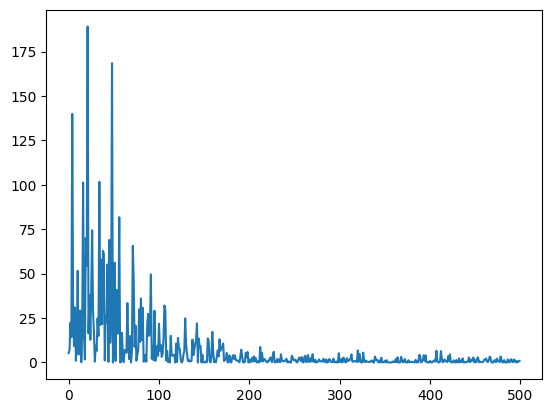

In [7]:
plt.plot(range(len(losses)), losses)